In [268]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error
from astropy.io import fits
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# quaia specphotoz 파일 그대로 가져오기
from specphotoz import RedshiftEstimatorkNN

from dustmaps.config import config
config.reset()

In [269]:
# fits file use - Q,D,S cross-matched, but based on the quaia
superset = fits.open('Quaia_DESIQSO_DR1_SDSS.fits')
data = superset[1].data

In [275]:
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ]   # Quaia_W12 is not used in this part.

# mask setup - SDSS 우선
mask = np.ones(len(data), dtype=bool)
for f in features + ['SDSS_Z']:
    mask &= ~np.isnan(data[f])

# Train setup
X = np.array([data[f][mask] for f in features]).T
y = data['SDSS_Z'][mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# NaN 제거 마스크 생성
mask_infer = np.ones(len(data), dtype=bool)
for f in features:
    mask_infer &= np.isfinite(data[f])

# inference data
X_infer = np.array([data[f][mask_infer] for f in features]).T
X_infer_scaled = scaler.transform(X_infer)

model = RedshiftEstimatorkNN(X_train=X_train, Y_train=y_train, X_apply=X_infer, K=5)
model.train()

z_pred, z_sigma = model.apply()

print("First 5 predicted redshifts:", z_pred[:5])
print("Uncertainty estimates (sigma_z):", z_sigma[:5])


Training
Building kdTree
Applying
Getting median Z of nearest neighbors
K = 5
A fraction 0.143 of objects have nearest neighbor w dist zero; cutting these from median
First 5 predicted redshifts: [0.406      1.67691278 1.43449533 2.578      2.468     ]
Uncertainty estimates (sigma_z): [0.03045678 0.16886565 0.26959156 0.26318    0.38489721]


In [276]:
print("number of estimation:", len(z_pred))
print("X_trains:", len(X_train),"\n", "y_trains:", len(y_train))
print("X_infers:", len(X_infer))
print("y:", y[:5], len(y))
print("y_test:", y_test[:5], len(y_test))

number of estimation: 1295502
X_trains: 185764 
 y_trains: 185764
X_infers: 1295502
y: [2.414      2.863      0.81013703 0.535312   0.47039869] 218546
y_test: [1.53786337 1.31399024 1.43591785 2.52       0.61794776] 32782


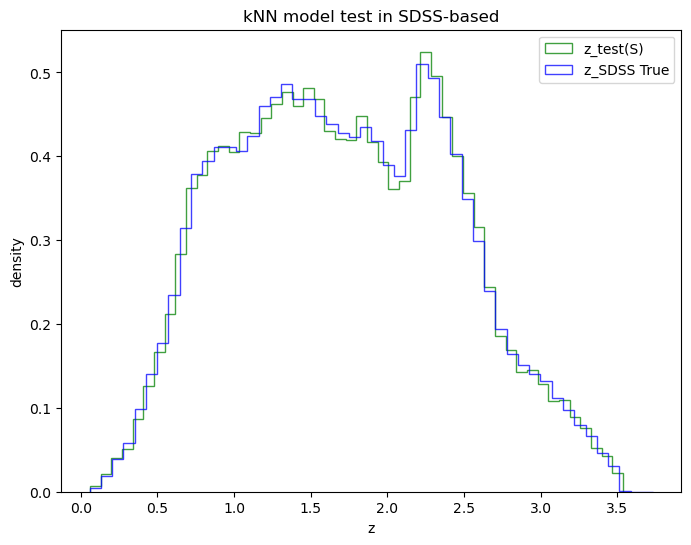

In [277]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(y_test, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_test(S)')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_SDSS True')

plt.title("kNN model test in SDSS-based")
plt.xlabel('z')
plt.ylabel('density')
plt.legend()

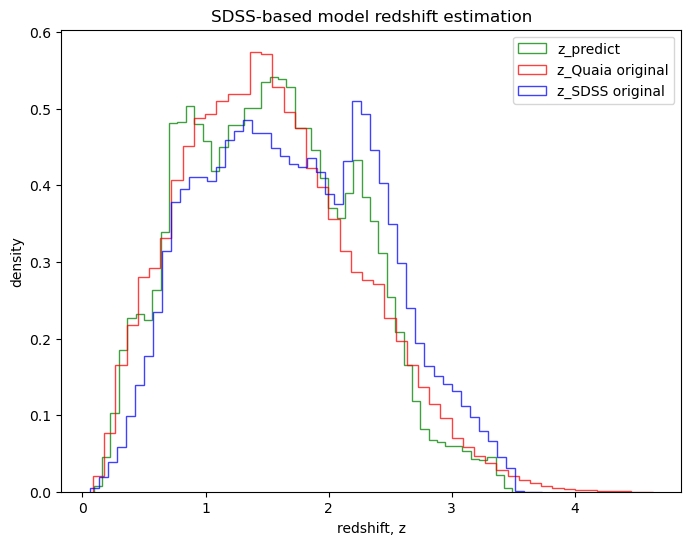

In [278]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_pred, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_SDSS original')

plt.title("SDSS-based model redshift estimation")
plt.xlabel('redshift, z')
plt.ylabel('density')
plt.legend()

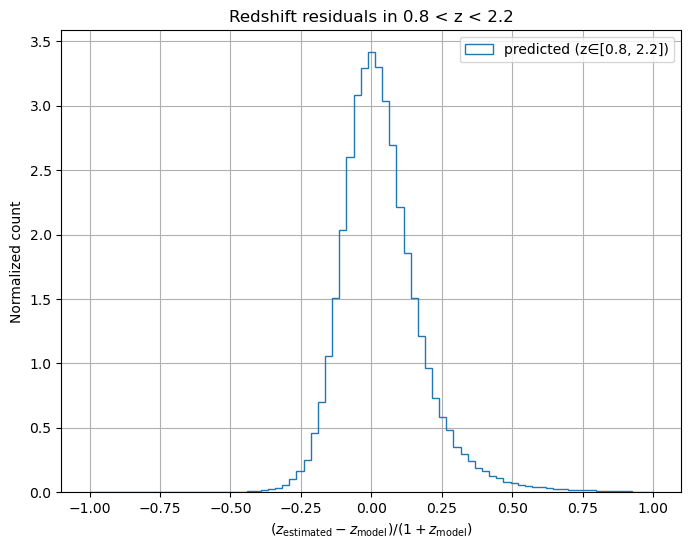

In [286]:
#k validation 노가다
z_sdss = data['SDSS_Z']

mask = (z_sdss >= 0.8) & (z_sdss <= 2.2)
z_sdss_sel = z_sdss[mask]
z_pred_sel = z_pred[mask]

dz1pz = (z_pred_sel - z_sdss_sel) / (1 + z_sdss_sel)

plt.figure(figsize=(8,6))
dz1pz_bins = np.linspace(-1.0, 1.0, 80)
plt.hist(dz1pz, bins=dz1pz_bins, histtype='step', density=True, label='predicted (z∈[0.8, 2.2])')
plt.xlabel(r'$(z_\text{estimated}-z_\text{model})/(1+z_\text{model})$')
plt.ylabel('Normalized count')
plt.legend()
plt.title(r'Redshift residuals in 0.8 < z < 2.2')
plt.grid(True)
plt.show()

In [252]:
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ]   # Quaia_W12 is not used in this part.

# mask setup - SDSS 우선
mask1 = np.ones(len(data), dtype=bool)
for f in features + ['DESI_Z']:
    mask1 &= ~np.isnan(data[f])

# Train setup
X1 = np.array([data[f][mask1] for f in features]).T
y1 = data['DESI_Z'][mask1]

X_train1, X_test, y_train1, y_test = train_test_split(X1, y1, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)

# NaN 제거 마스크 생성
mask_infer1 = np.ones(len(data), dtype=bool)
for f in features:
    mask_infer1 &= np.isfinite(data[f])

# inference data
X_infer1 = np.array([data[f][mask_infer1] for f in features]).T
X_infer_scaled = scaler.transform(X_infer1)

model = RedshiftEstimatorkNN(X_train=X_train1, Y_train=y_train1, X_apply=X_infer1, K=5)
model.train()

z_pred1, z_sigma1 = model.apply()

print("First 5 predicted redshifts:", z_pred1[:5])
print("Uncertainty estimates (sigma_z):", z_sigma1[:5])


Training
Building kdTree
Applying
Getting median Z of nearest neighbors
K = 5
A fraction 0.207 of objects have nearest neighbor w dist zero; cutting these from median
First 5 predicted redshifts: [0.37167241 1.69742657 1.40691907 2.27908506 1.64488703]
Uncertainty estimates (sigma_z): [0.04563434 0.13192567 0.06798569 0.32255718 0.50604285]


In [253]:
print("number of estimation:", len(z_pred1))

number of estimation: 1295502


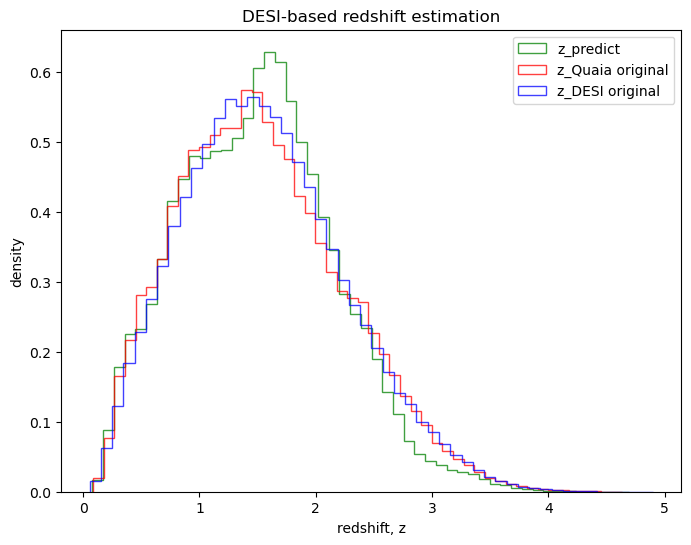

In [279]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_pred1, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_DESI original')

plt.title("DESI-based redshift estimation")
plt.xlabel('redshift, z')
plt.ylabel('density')
plt.legend()

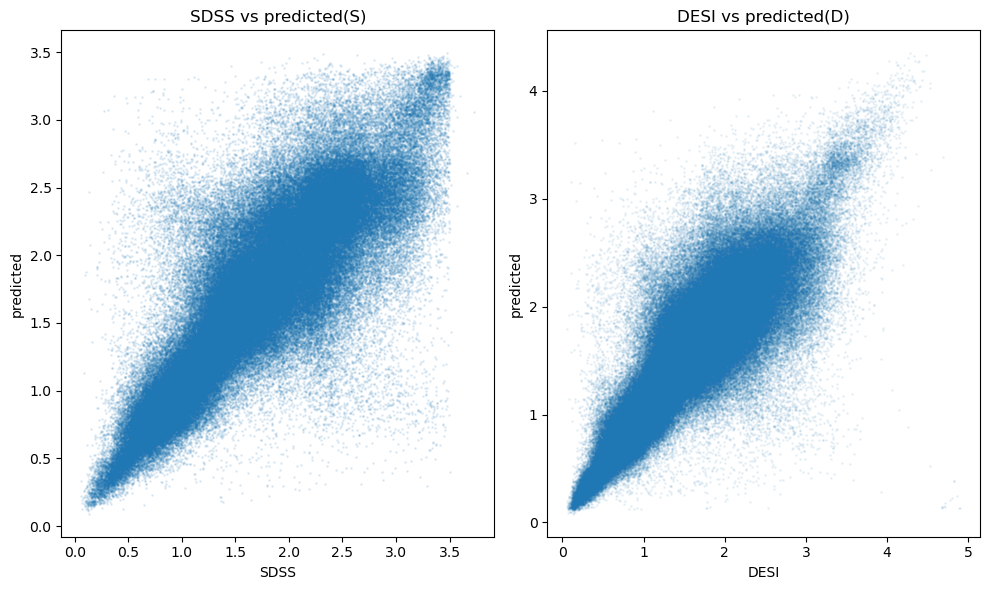

In [287]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(data["SDSS_Z"], z_pred, alpha=0.1, s=1)
plt.xlabel("SDSS")
plt.ylabel("predicted")
plt.title("SDSS vs predicted(S)")

plt.subplot(1, 2, 2)
plt.scatter(data["DESI_Z"], z_pred1, alpha=0.07, s=1)
plt.xlabel("DESI")
plt.ylabel("predicted")
plt.title("DESI vs predicted(D)")

# plt.subplot(1, 3, 3)
# plt.scatter(data["DESI_Z"], z_pred1, alpha=0.07, s=1)
# plt.xlabel("DESI")
# plt.ylabel("predicted")
# plt.title("DESI vs predicted(D)")

plt.tight_layout()
plt.show()


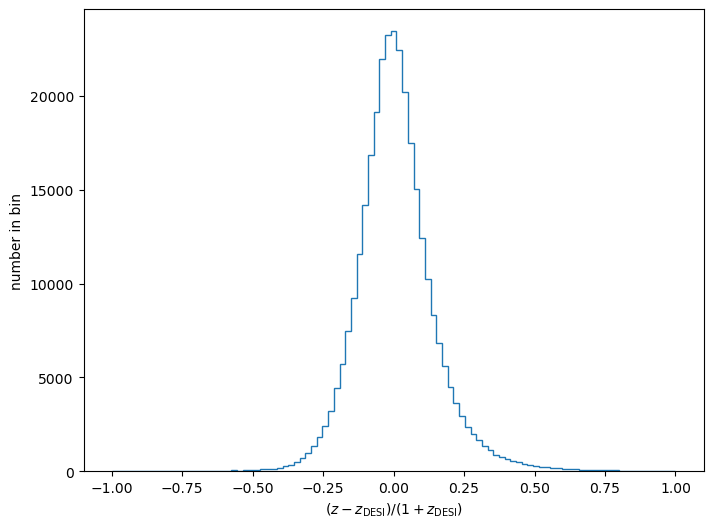

In [256]:
#k validation 노가다
z_desi = data['DESI_Z']

dz2pz = (z_pred1 - z_desi)/(1+z_desi)

plt.figure(figsize=(8,6))

dz1pz_bins = np.linspace(-1.0, 1.0, 100)
plt.hist(dz2pz, bins=dz1pz_bins, histtype='step', label='predicted(D)')
plt.xlabel(r'$(z-z_\mathrm{DESI})/(1+z_\mathrm{DESI})$')
plt.ylabel('number in bin')
plt.legend

plt.show()

In [257]:
# 보정값 z_spec - z_quaia 버전

features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg']

mask = np.ones(len(data), dtype=bool)
for f in features + ['SDSS_Z', 'redshift_quaia']:
    mask &= np.isfinite(data[f])

X = np.array([data[f][mask] for f in features]).T

# residual target: z_spec - z_quaia
y_residual = data['SDSS_Z'][mask] - data['redshift_quaia'][mask]

X_train, X_test, y_train, y_test = train_test_split(X, y_residual, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

mask_infer = np.ones(len(data), dtype=bool)
for f in features + ['redshift_quaia']:
    mask_infer &= np.isfinite(data[f])

X_infer = np.array([data[f][mask_infer] for f in features]).T
X_infer_scaled = scaler.transform(X_infer)

z_quaia_infer = data['redshift_quaia'][mask_infer]
model = RedshiftEstimatorkNN(X_train=X_train_scaled, Y_train=y_train, X_apply=X_infer_scaled, K=27)
model.train()

# residual 예측
z_residual_pred, z_sigma = model.apply()

# 최종 보정된 z
z_corrected = z_quaia_infer + z_residual_pred

# 결과 출력
print("First 5 corrected redshifts:", z_corrected[:5])
print("Uncertainty estimates (sigma_z):", z_sigma[:5])


Training
Building kdTree
Applying
Getting median Z of nearest neighbors
K = 27
A fraction 0.143 of objects have nearest neighbor w dist zero; cutting these from median
First 5 corrected redshifts: [0.41050026 1.73520529 1.51306701 2.429176   2.84999885]
Uncertainty estimates (sigma_z): [0.00886145 0.00896191 0.0165183  0.02172866 0.01950695]


In [258]:
print(len(z_corrected))

1295502


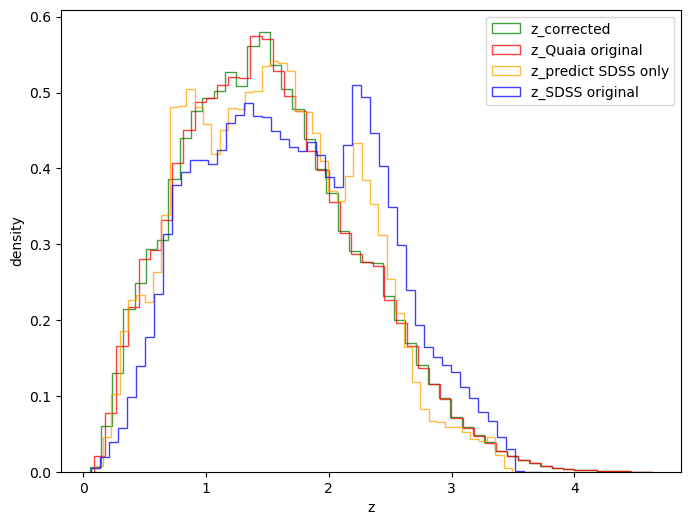

In [259]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_corrected, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_corrected')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')
plt.hist(z_pred, bins=50, alpha=alpha, color='orange', lw=lw, density=density, histtype=histtype, label='z_predict SDSS only')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_SDSS original')


plt.xlabel('z')
plt.ylabel('density')
plt.legend()

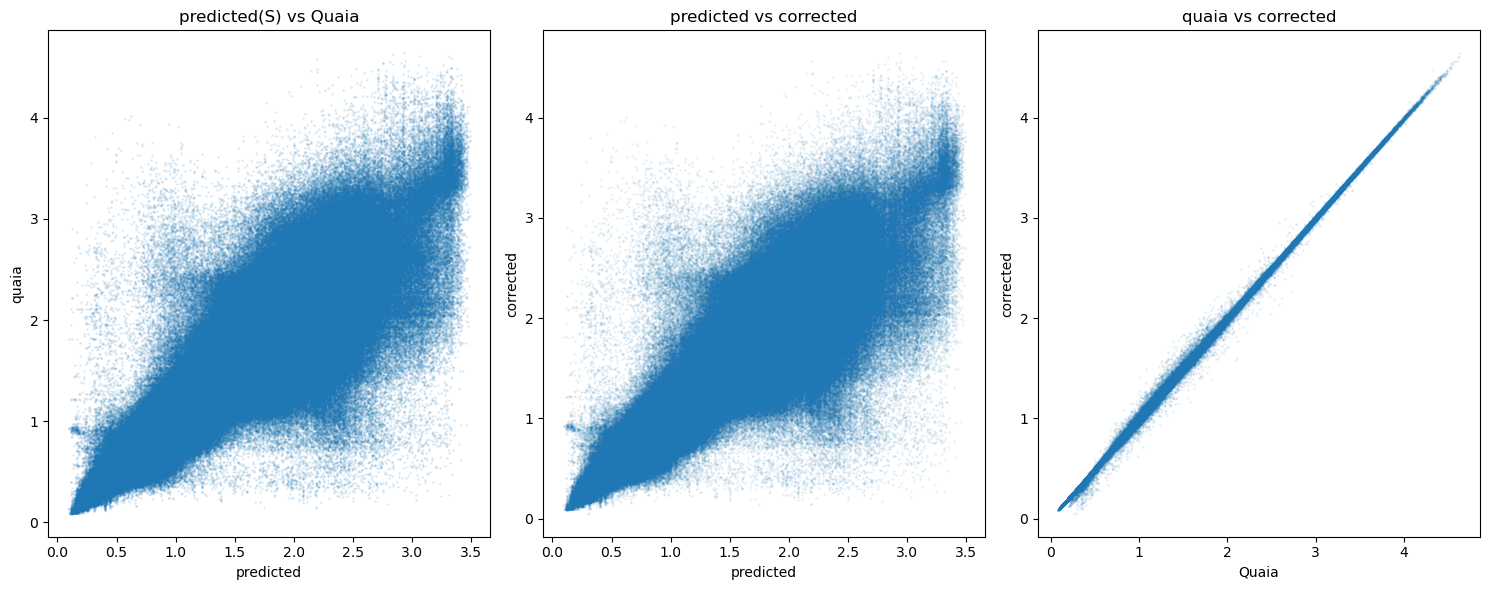

In [260]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.scatter(z_pred, data["redshift_quaia"], alpha=0.1, s=1)
plt.xlabel("predicted")
plt.ylabel("quaia")
plt.title("predicted(S) vs Quaia")

plt.subplot(1, 3, 2)
plt.scatter(z_pred, z_corrected, alpha=0.07, s=1)
plt.xlabel("predicted")
plt.ylabel("corrected")
plt.title("predicted vs corrected")

plt.subplot(1, 3, 3)
plt.scatter(data["redshift_quaia"], z_corrected, alpha=0.07, s=1)
plt.xlabel("Quaia")
plt.ylabel("corrected")
plt.title("quaia vs corrected")

plt.tight_layout()
plt.show()


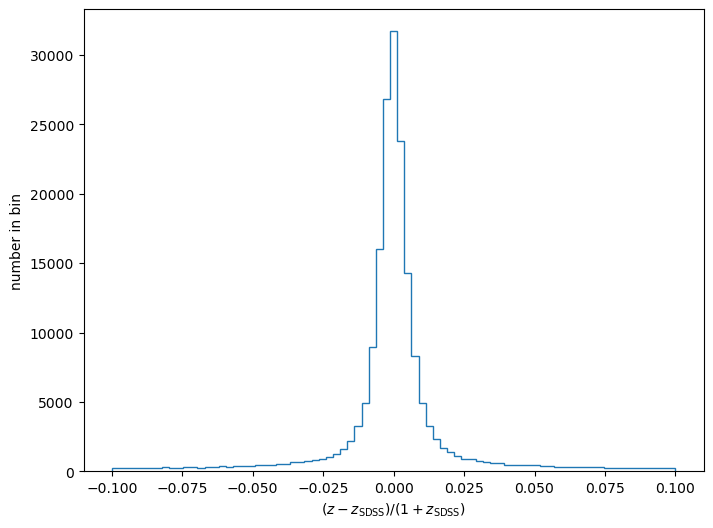

In [261]:
#k validation 노가다
z_quaia = data['redshift_quaia']

dz3pz = (z_corrected - z_quaia)/(1+z_quaia)
dzpz = (z_corrected - z_sdss)/(1+z_sdss)

plt.figure(figsize=(8,6))

dz1pz_bins = np.linspace(-0.1, 0.1, 80)
plt.hist(dzpz, bins=dz1pz_bins, histtype='step', label='corrected')
# plt.hist(dz3pz, bins=dz1pz_bins, histtype='step', label='predicted(S)')

plt.xlabel(r'$(z-z_\mathrm{SDSS})/(1+z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend

plt.show()

In [262]:
# SDSS+DESI

features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ]   # Quaia_W12 is not used in this part.

# mask setup 
mask2 = np.ones(len(data), dtype=bool)
for f in features + ['DESI_Z', 'SDSS_Z']:
    mask2 &= ~np.isnan(data[f])

# Train setup
X2 = np.array([data[f][mask2] for f in features]).T
y2 = data['DESI_Z'][mask2] # DESI priority

X_train2, X_test, y_train2, y_test = train_test_split(X2, y2, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)

# NaN 제거 마스크 생성
mask_infer2 = np.ones(len(data), dtype=bool)
for f in features:
    mask_infer2 &= np.isfinite(data[f])

# inference data
X_infer2 = np.array([data[f][mask_infer2] for f in features]).T
X_infer_scaled = scaler.transform(X_infer2)

model = RedshiftEstimatorkNN(X_train=X_train2, Y_train=y_train2, X_apply=X_infer2, K=5)
model.train()

z_pred2, z_sigma2 = model.apply()

print("First 5 predicted redshifts:", z_pred2[:5])
print("Uncertainty estimates (sigma_z):", z_sigma2[:5])


Training
Building kdTree
Applying
Getting median Z of nearest neighbors
K = 5
A fraction 0.066 of objects have nearest neighbor w dist zero; cutting these from median
First 5 predicted redshifts: [0.37635486 1.67464444 1.35753867 2.433051   2.49643982]
Uncertainty estimates (sigma_z): [0.03049914 0.19292068 0.07795348 0.13417861 0.32914406]


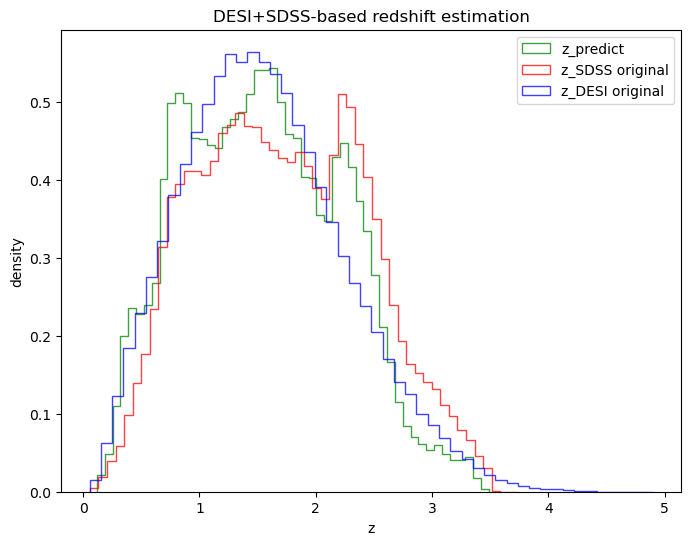

In [281]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_pred2, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_SDSS original')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_DESI original')

plt.title("DESI+SDSS-based redshift estimation")
plt.xlabel('z')
plt.ylabel('density')
plt.legend()

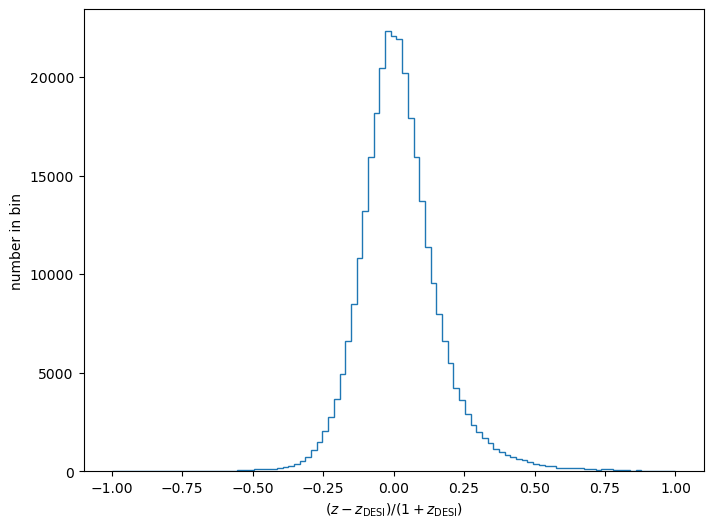

In [264]:
#k validation 노가다
dz4pz = (z_pred2 - z_desi)/(1+z_desi)

plt.figure(figsize=(8,6))

dz1pz_bins = np.linspace(-1.0, 1.0, 100)
plt.hist(dz4pz, bins=dz1pz_bins, histtype='step', label='predicted(D+S)')
plt.xlabel(r'$(z-z_\mathrm{DESI})/(1+z_\mathrm{DESI})$')
plt.ylabel('number in bin')
plt.legend

plt.show()

### csv file test for Revolver

In [265]:
superset[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  236 / length of dimension 1                          
NAXIS2  =              1295502 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   38 / number of table fields                         
TTYPE1  = 'source_id'                                                           
TFORM1  = 'K       '                                                            
TNULL1  =               999999                                                  
TTYPE2  = 'unwise_objid'                                                        
TFORM2  = '16A     '        

ra = data['ra']
dec = data['dec']

selec_df = pd.read_csv('Revolver-main/catalog_G20.5_20231010.csv', 
                       header=None, 
                       delim_whitespace=True)
sf = selec_df.iloc[:, -1].values

print(f"RA 길이: {len(ra)}")
print(f"z_pred1 길이: {len(z_pred2)}")
print(f"selection_function 길이: {len(sf)}")
print(sf[:5])

output_array = np.vstack([ra, dec, z_pred2, sf]).T.astype(np.float64)
np.savetxt('predict_DS_test.csv', output_array, fmt='%.15f', delimiter=' ')